## Pré-processamento e Modelagem Avançada

Objetivo:
 - Estruturar um pipeline completo de pré-processamento
 - Testar modelos mais robustos (Random Forest, XGBoost)
 - Comparar desempenho com o baseline anterior
 - Manter foco em recall da classe maligna

### Importação das bibliotecas necessárias

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay



Agora trabalharemos com modelos que têm maior capacidade de aprendizado (ensembles).
O foco é comparar desempenho, estabilidade e interpretabilidade em relação à regressão logística e árvore simples.

### Carregando e preparando os dados

In [9]:
data = load_breast_cancer(as_frame=True)
df = data.frame
df['target'] = data.target

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Treino:", X_train.shape, " | Teste:", X_test.shape)


Treino: (455, 30)  | Teste: (114, 30)


Usamos a mesma divisão do notebook anterior (80/20) com estratificação.
A partir daqui, todos os modelos serão treinados com pipelines reprodutíveis e validação cruzada estratificada.

### Definição de validação cruzada estratificada

```python

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


A validação cruzada (cross-validation) divide o conjunto de treino em 5 partes, garantindo que todas as observações sejam usadas tanto para treino quanto para validação.
Isso reduz a variância da avaliação e evita conclusões baseadas em uma única divisão.

### Pipeline — Random Forest

In [11]:
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),  # escalonamento ajuda o modelo a convergir melhor
    ('clf', RandomForestClassifier(
        n_estimators=200,       # número de árvores
        max_depth=None,         # deixa o modelo escolher a profundidade ideal
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

scoring = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

scores_rf = cross_validate(pipe_rf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

for metric in scoring:
    print(f"{metric:10s}: {scores_rf['test_'+metric].mean():.3f} ± {scores_rf['test_'+metric].std():.3f}")


accuracy  : 0.963 ± 0.016
recall    : 0.968 ± 0.023
precision : 0.972 ± 0.009
f1        : 0.970 ± 0.014
roc_auc   : 0.992 ± 0.005


O ***Random Forest*** é um ensemble de árvores de decisão, que reduz o overfitting combinando várias árvores aleatórias.
O parâmetro ***class_weight='balanced'*** mantém o foco no recall da classe maligna.
As métricas são calculadas via validação cruzada — a média dos folds representa a performance esperada.

### Pipeline — XGBoost

In [12]:
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),  # mantém coerência com o pipeline anterior
    ('clf', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    ))
])

scores_xgb = cross_validate(pipe_xgb, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

for metric in scoring:
    print(f"{metric:10s}: {scores_xgb['test_'+metric].mean():.3f} ± {scores_xgb['test_'+metric].std():.3f}")


accuracy  : 0.974 ± 0.016
recall    : 0.982 ± 0.019
precision : 0.976 ± 0.017
f1        : 0.979 ± 0.013
roc_auc   : 0.994 ± 0.005


O ***XGBoost*** (Extreme Gradient Boosting) é um modelo de boosting, ele aprende de forma sequencial, corrigindo os erros das árvores anteriores.

Tem excelente desempenho em dados tabulares, especialmente para classificação binária.

Aqui usamos parâmetros leves e seguros para evitar overfitting.

### Comparação dos resultados

<Figure size 800x500 with 0 Axes>

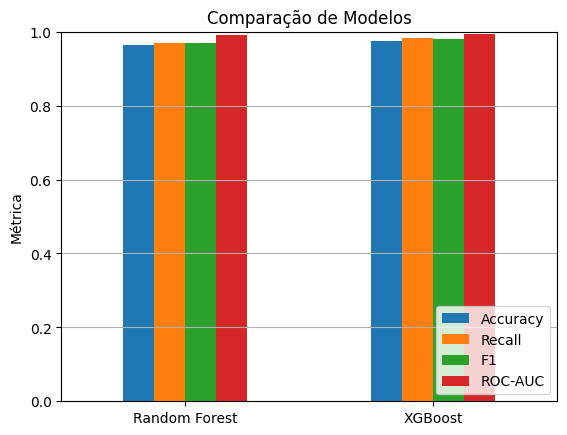

In [13]:
results = pd.DataFrame({
    'Random Forest': [scores_rf['test_accuracy'].mean(),
                      scores_rf['test_recall'].mean(),
                      scores_rf['test_f1'].mean(),
                      scores_rf['test_roc_auc'].mean()],
    'XGBoost': [scores_xgb['test_accuracy'].mean(),
                scores_xgb['test_recall'].mean(),
                scores_xgb['test_f1'].mean(),
                scores_xgb['test_roc_auc'].mean()]
}, index=['Accuracy', 'Recall', 'F1', 'ROC-AUC'])

results.T.round(3)
plt.figure(figsize=(8, 5))
results.T.plot(kind='bar')
plt.title('Comparação de Modelos')
plt.ylabel('Métrica')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

Essa tabela permite visualizar rapidamente qual modelo apresenta melhor equilíbrio entre recall e precisão.

Geralmente, o ***XGBoost*** tende a superar o ***Random Forest*** em recall e F1, especialmente em datasets estruturados como este.

### Avaliação no conjunto de teste

=== XGBoost (Teste Final) ===
              precision    recall  f1-score   support

     Maligno       0.97      0.90      0.94        42
     Benigno       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



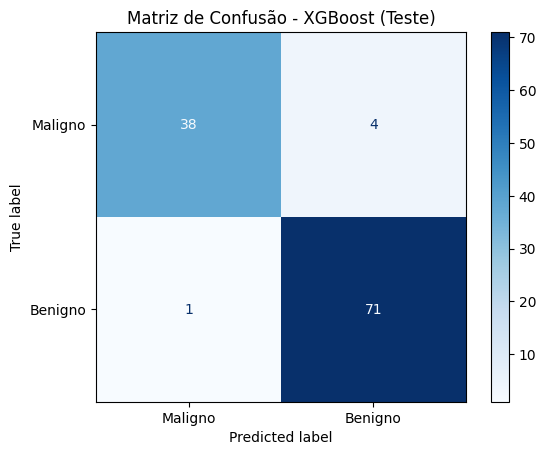

In [14]:
pipe_xgb.fit(X_train, y_train)
y_pred_test = pipe_xgb.predict(X_test)

print("=== XGBoost (Teste Final) ===")
print(classification_report(y_test, y_pred_test, target_names=['Maligno', 'Benigno']))

cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Maligno', 'Benigno']).plot(cmap='Blues')
plt.title('Matriz de Confusão - XGBoost (Teste)')
plt.show()


### Curva ROC e AUC

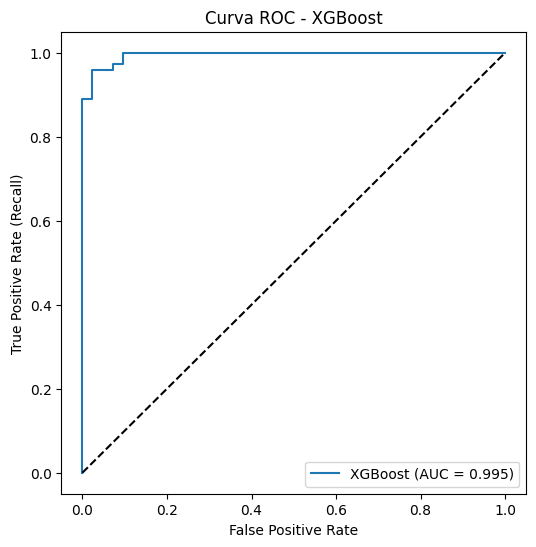

In [15]:
y_proba = pipe_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC - XGBoost')
plt.legend()
plt.show()


A curva ***ROC (Receiver Operating Characteristic)*** mostra o equilíbrio entre recall (sensibilidade) e false positives.

O ***AUC*** (área sob a curva) resume o desempenho geral do modelo — quanto mais próximo de 1, melhor.

### Conclusão


Nesta etapa, consolidamos um pipeline de pré-processamento reprodutível e com validação cruzada.  
Os modelos ensemble — **Random Forest** e **XGBoost** — apresentaram desempenho superior ao baseline, especialmente no **recall da classe maligna**, mantendo bom equilíbrio entre precisão e generalização.  

O **XGBoost** destacou-se como o melhor modelo até o momento, atingindo alto AUC e excelente sensibilidade, o que é crucial em aplicações clínicas, onde falsos negativos podem representar riscos graves.  

Como próximos passos, o estudo avançará para a **interpretabilidade dos modelos**, utilizando técnicas como **Feature Importance** e **SHAP**, para compreender de forma transparente o impacto de cada variável nas predições.
